# Classification forecasting for categorical time series

Recursive multi-step forecasting is a technique used to predict future values in a time series by using previous predictions as inputs for subsequent forecasts.

In the context of categorical time series, where the values belong to discrete categories rather than continuous values, the model is trained to predict the probability distribution over the possible categories for each future time step. The most likely category for the current time step is then used as input for predicting the next time step, and this process continues recursively.

Although the process is conceptually very similar to that used for forecasting continuous time series, many challenges arise due the need to encode and decode categorical variables, as well as allowing the underlying machine learning model to handle categorical data effectively.

**Skforecast** provides the class [`ForecasterRecursiveClassifier`](https://skforecast.org/0.18.0/api/forecasterrecursive#forecasterrecursiveclassifier) to facilitate recursive multi-step forecasting for categorical time series, automatically managing the encoding and decoding of categorical variables, and integrating seamlessly with various machine learning models that support classification tasks.

## Libraries and data

In [1]:
# Libraries
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap, BoundaryNorm
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay, calibration_curve
from skforecast.datasets import fetch_dataset
from skforecast.preprocessing import RollingFeaturesClassification
from skforecast.recursive import ForecasterRecursiveClassifier
from skforecast.model_selection import (
    TimeSeriesFold, OneStepAheadFold, backtesting_forecaster, bayesian_search_forecaster
)
from skforecast.plot import set_dark_theme

In [2]:
# Data download
# ==============================================================================
data = fetch_dataset(name='vic_electricity_classification')
data

╭──────────────────────── vic_electricity_classification ────────────────────────╮
│ Description:                                                                   │
│ Hourly electricity demand for Victoria, Australia classified into three        │
│ categories: 'low', 'medium' and 'high' according to the 20th and 80th          │
│ percentiles. The dataset also includes temperature, holiday indicator and hour │
│ of the day as features.                                                        │
│                                                                                │
│ Source:                                                                        │
│ O'Hara-Wild M, Hyndman R, Wang E, Godahewa R (2022).tsibbledata: Diverse       │
│ Datasets for 'tsibble'. https://tsibbledata.tidyverts.org/,                    │
│ https://github.com/tidyverts/tsibbledata/.                                     │
│ https://tsibbledata.tidyverts.org/reference/vic_elec.html                      │
│                                                                                │
│ URL:                                                                           │
│ https://raw.githubusercontent.com/skforecast/skforecast-                       │
│ datasets/main/data/vic_electricity_classification.csv                          │
│                                                                                │
│ Shape: 8736 rows x 5 columns                                                   │
╰────────────────────────────────────────────────────────────────────────────────╯

,Demand,Temperature,Holiday,Hour_of_day,Demand_raw
Time,,,,,
2014-01-01 01:00:00,low,24.80,1.0,1,3730.065980
2014-01-01 02:00:00,medium,25.90,1.0,2,3858.473927
2014-01-01 03:00:00,medium,25.30,1.0,3,3851.415438
2014-01-01 04:00:00,medium,23.65,1.0,4,3838.972926
2014-01-01 05:00:00,medium,20.70,1.0,5,3860.540970
...,...,...,...,...,...
2014-12-30 20:00:00,low,12.10,0.0,20,3527.232855
2014-12-30 21:00:00,medium,12.30,0.0,21,3846.439766
2014-12-30 22:00:00,medium,14.05,0.0,22,3961.529675


In [3]:
# Distribution of classes in the series
# ==============================================================================
print("Distribution of classes:")
data['Demand'].value_counts(normalize=True).round(2)

Distribution of classes:


Demand
medium    0.6
low       0.2
high      0.2
Name: proportion, dtype: float64

In [4]:
# Split train-test
# ==============================================================================
end_train = '2014-10-31 23:59:00'
data_train = data[:end_train].copy()
data_test  = data[end_train:].copy()

print(
    f"Train dates : {data_train.index.min()} --- "
    f"{data_train.index.max()}  (n={len(data_train)})"
)
print(
    f"Test dates  : {data_test.index.min()} --- "
    f"{data_test.index.max()}  (n={len(data_test)})"
)

Train dates : 2014-01-01 01:00:00 --- 2014-10-31 23:00:00  (n=7295)
Test dates  : 2014-11-01 00:00:00 --- 2014-12-31 00:00:00  (n=1441)


## Plotting categorical time series

Visualizing categorical time series can be challenging due to the discrete nature of the data. Most of the standard plotting libraries require numerical inputs to create plots which means that categorical data needs to be encoded into numerical format for visualization purposes.

In [5]:
# Data preprocessing
# ==============================================================================
# Encode categorical variable as numerical for plotting
encode_mapping = {'low': 0, 'medium': 1, 'high': 2}
print(f"Encoding map: {encode_mapping}")
data['encoded_value'] = data['Demand'].map(encode_mapping).astype(float)
data_train['encoded_value'] = data_train['Demand'].map(encode_mapping).astype(float)
data_test['encoded_value'] = data_test['Demand'].map(encode_mapping).astype(float)
data.head(3)

Encoding map: {'low': 0, 'medium': 1, 'high': 2}


,Demand,Temperature,Holiday,Hour_of_day,Demand_raw,encoded_value
Time,,,,,,
2014-01-01 01:00:00,low,24.8,1.0,1,3730.065980,0.0
2014-01-01 02:00:00,medium,25.9,1.0,2,3858.473927,1.0
2014-01-01 03:00:00,medium,25.3,1.0,3,3851.415438,1.0


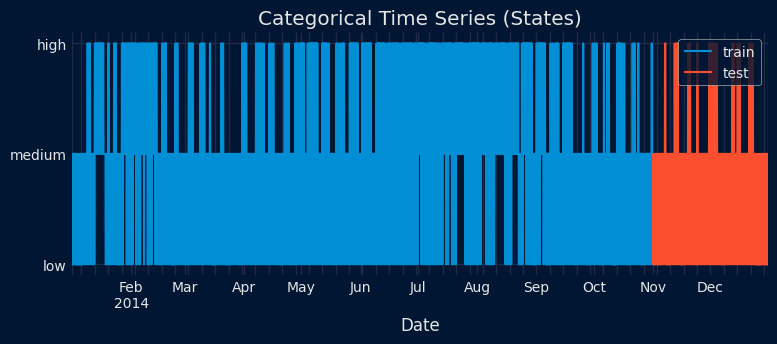

In [6]:
# Plot: line plot
# ==============================================================================
set_dark_theme()
fig, ax = plt.subplots(figsize=(8, 3))
data_train['encoded_value'].plot(ax=ax, label='train')
data_test['encoded_value'].plot(ax=ax, label='test')
y_ticks = list(encode_mapping.values())
y_labels = list(encode_mapping.keys())
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_labels)
ax.set_title("Categorical Time Series (States)")
ax.set_xlabel("Date")
ax.legend();

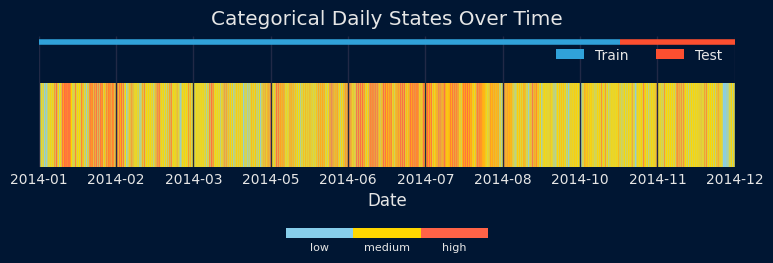

In [7]:
# Plot: 1-row heatmap-style scatter
# ==================================================================================================
colors = ["skyblue", "gold", "tomato"]
cmap = ListedColormap(colors)
norm = BoundaryNorm([0, 1, 2, 3], cmap.N)
stripe_height = 20
state_array = np.tile(data["encoded_value"].values, (stripe_height, 1))
train_mask = data.index <= pd.to_datetime(end_train)
train_indices = np.where(train_mask)[0]
test_indices = np.where(~train_mask)[0]

fig, ax = plt.subplots(figsize=(8, 2.5))
ax.imshow(
    state_array,
    aspect="auto",
    cmap=cmap,
    norm=norm,
    extent=[0, len(data) - 1, 0, stripe_height],
)

ax.hlines(y=30, xmin=train_indices[0], xmax=train_indices[-1], color="#30a2da", linewidth=4)
ax.hlines(y=30, xmin=test_indices[0], xmax=test_indices[-1], color="#fc4f30", linewidth=4)
ax.set_yticks([])
ax.set_frame_on(False)
tick_indices = np.linspace(0, len(data) - 1, 10, dtype=int)
ax.set_xticks(tick_indices)
ax.set_xticklabels([data.index[i].strftime("%Y-%m") for i in tick_indices], rotation=0, ha="center")
ax.set_xlabel("Date")
ax.set_title("Categorical Daily States Over Time", pad=8)

cbar = fig.colorbar(
    plt.cm.ScalarMappable(cmap=cmap, norm=norm),
    ax=ax,
    orientation="horizontal",
    ticks=[0.5, 1.5, 2.5],
    pad=0.3,       # space between plot and colorbar
    fraction=0.05,  # thickness
    aspect=20       # length-to-height ratio
)
cbar.outline.set_visible(False)
cbar.ax.set_xticklabels(["low", "medium", "high"], fontsize=8)
cbar.set_label("", labelpad=2, fontsize=9)

legend_elements = [
    Patch(facecolor="#30a2da", label="Train"),
    Patch(facecolor="#fc4f30", label="Test"),
]
ax.legend(handles=legend_elements, loc="upper right", frameon=False, ncol=2, borderaxespad=0.5);

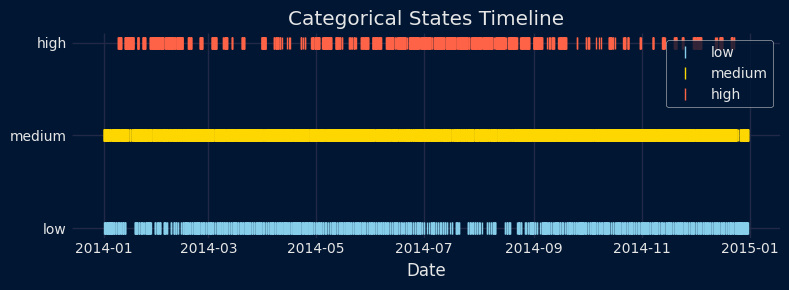

In [8]:
# Plot: states timeline
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 3))
color_map = {"low": "skyblue", "medium": "gold", "high": "tomato"}
for state, color in color_map.items():
    mask = data["Demand"] == state
    ax.plot(
        data.index[mask], [state] * mask.sum(), '|', color=color, markersize=8, label=state
    )
ax.set_yticks(y_ticks)
ax.set_title("Categorical States Timeline")
ax.set_xlabel("Date")
ax.legend()
plt.tight_layout()
plt.show()


## Create and train forecaster

When working with categorical time series, a common challenge arises: not only is the target variable categorical, but the lagged values used as predictors are also categorical, as they represent previous observations of the target variable.

Most classification algorithms can handle categorical target variables; however, many cannot directly process categorical predictors. In such cases, it is necessary to encode the categorical features into a numerical format prior to training the model.

The `features_encoding` parameter in the [`ForecasterRecursiveClassifier`](https://skforecast.org/latest/api/forecasterrecursive#forecasterrecursiveclassifier) class specifies how the categorical features derived from the target series (e.g., lagged values and window features) are encoded before fitting the underlying machine learning model. The parameter accepts the following options:

- `auto`: Use a categorical data type if the classifier supports native categorical features (such as LightGBM, CatBoost, XGBoost, or HistGradientBoostingClassifier). Otherwise, fallback to numerical encoding.
  
- `categorical`: Enforce the use of a categorical data type. This requires a classifier capable of handling native categorical features.
  
- `ordinal`: Apply ordinal encoding (0, 1, 2, …). In this case, the classifier interprets the encoded values as numeric, implicitly assuming an ordinal relationship among the categories (for example, 'low' < 'medium' < 'high').

Proper encoding of categorical features is crucial to ensure that the model can accurately interpret and leverage the information contained in previous observations of the target series.

In [9]:
# Create and fit forecaster with rolling window features
# ==============================================================================
forecaster = ForecasterRecursiveClassifier(
                 regressor         = HistGradientBoostingClassifier(random_state=123),
                 lags              = 24,
                 window_features   = RollingFeaturesClassification(stats=['proportion'], window_sizes=72),
                 features_encoding = 'auto', 
             )

forecaster.fit(y=data_train['Demand'], exog=data_train[['Temperature', 'Holiday', 'Hour_of_day']])
forecaster

============================= 
ForecasterRecursiveClassifier 
============================= 
Classifier: HistGradientBoostingClassifier 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Window features: ['roll_proportion_72'] 
Window size: 72 
Series name: Demand 
Classes: ['high', 'low', 'medium'] 
Number of classes: 3 
Exogenous included: True 
Exogenous names: Temperature, Holiday, Hour_of_day 
Feature encoding: auto 
Transformer for exog: None 
Weight function included: False 
Training range: [Timestamp('2014-01-01 01:00:00'), Timestamp('2014-10-31 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: <Hour> 
Classifier parameters: 
    {'categorical_features': 'from_dtype', 'class_weight': None, 'early_stopping':
    'auto', 'interaction_cst': None, 'l2_regularization': 0.0, 'learning_rate':
    0.1, 'loss': 'log_loss', 'max_bins': 255, 'max_depth': None, 'max_features':
    1.0, 'max_iter': 100, 'max_leaf_nodes': 31, 'min_samples_leaf': 20,
    'monotonic_cst': None, 'n_iter_no_change': 10, 'random_state': 123,
    'scoring': 'loss', 'tol': 1e-07, 'validation_fraction': 0.1, 'verbose': 0,
    'warm_start': False} 
fit_kwargs: {} 
Creation date: 2025-11-17 16:22:53 
Last fit date: 2025-11-17 16:22:53 
Skforecast version: 0.19.0 
Python version: 3.13.9 
Forecaster id: None

## Prediction

In [10]:
# Predict
# ==============================================================================
predictions = forecaster.predict(steps=24, exog=data_test[['Temperature', 'Holiday', 'Hour_of_day']])
predictions

2014-11-01 00:00:00    medium
2014-11-01 01:00:00    medium
2014-11-01 02:00:00    medium
2014-11-01 03:00:00    medium
2014-11-01 04:00:00    medium
2014-11-01 05:00:00    medium
2014-11-01 06:00:00    medium
2014-11-01 07:00:00    medium
2014-11-01 08:00:00    medium
2014-11-01 09:00:00      high
2014-11-01 10:00:00      high
2014-11-01 11:00:00    medium
2014-11-01 12:00:00    medium
2014-11-01 13:00:00    medium
2014-11-01 14:00:00    medium
2014-11-01 15:00:00    medium
2014-11-01 16:00:00    medium
2014-11-01 17:00:00       low
2014-11-01 18:00:00       low
2014-11-01 19:00:00       low
2014-11-01 20:00:00    medium
2014-11-01 21:00:00    medium
2014-11-01 22:00:00    medium
2014-11-01 23:00:00    medium
Freq: h, Name: pred, dtype: object

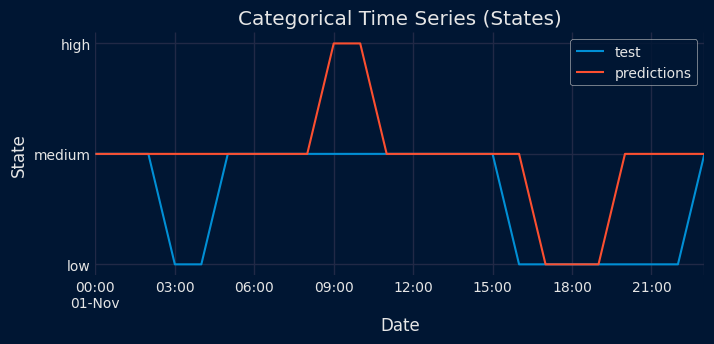

In [11]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data_test.loc[predictions.index, 'encoded_value'].plot(ax=ax, label='test')
(
    predictions
    .to_frame()
    .assign(encoded_value=predictions.map(encode_mapping))['encoded_value']
    .plot(ax=ax, label='predictions')
)
y_ticks = list(encode_mapping.values())
y_labels = list(encode_mapping.keys())
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_labels)
ax.set_title("Categorical Time Series (States)")
ax.set_xlabel("Date")
ax.set_ylabel("State")
ax.legend();

In [12]:
# Prediction metrics
# ==============================================================================
error_mse = accuracy_score(
                y_true = data_test.loc[predictions.index, 'Demand'],
                y_pred = predictions
            )
print(f"Test error (accuracy): {error_mse}")
print("Classification Report \n---------------------")
print(
    classification_report(
        data.loc[predictions.index, 'Demand'],
        predictions
    )
)

Test error (accuracy): 0.6666666666666666
Classification Report 
---------------------
              precision    recall  f1-score   support

        high       0.00      0.00      0.00         0
         low       1.00      0.33      0.50         9
      medium       0.68      0.87      0.76        15

    accuracy                           0.67        24
   macro avg       0.56      0.40      0.42        24
weighted avg       0.80      0.67      0.67        24



/home/joaquin/miniconda3/envs/skforecast_19_py13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/joaquin/miniconda3/envs/skforecast_19_py13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/joaquin/miniconda3/envs/skforecast_19_py13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mod

## Predict probabilities

`ForecasterRecursiveClassifier` includes the method `predict_proba` which allows to obtain the predicted probabilities for each category at each forecasted time step. Internally, this method calls the `predict_proba` method of the underlying classifier used inside the forecaster.


<div role="alert"
    style="background: rgba(255,145,0,.08); border-left: 6px solid #ff9100;
        border-radius: 6px; padding: 10px 12px; margin: 1em 0;">

<p style="display:flex; align-items:center; font-size:1rem; color:#ff9100;
        margin:0 0 6px 0; font-weight:600;">
<span style="margin-right:6px; font-size:18px;">⚠️</span>
<strong style="margin-right:6px; font-size:18px;">Warning</strong>
</p>

<p style="margin:0; color:inherit;">
It is important to note that these probabilities come from the classifier’s <code>predict_proba</code> method. Their calibration and reliability depend on the specific model used. For example, in scikit-learn, <code>predict_proba</code> returns scores that approximate probabilities, but these are not always well-calibrated or truly probabilistic. See section on <a href="./py72-classification-forecasting#Probability_calibration">Probability Calibration</a> for more details.
</p>

</div>

In [13]:
# Predict probabilities
# ==============================================================================
predictions = forecaster.predict_proba(steps=24, exog=data_test[['Temperature', 'Holiday', 'Hour_of_day']])
predictions

,high_proba,low_proba,medium_proba
2014-11-01 00:00:00,0.001643,0.001311,0.997046
2014-11-01 01:00:00,0.002286,0.004299,0.993415
2014-11-01 02:00:00,0.000829,0.001231,0.997940
2014-11-01 03:00:00,0.000601,0.002429,0.996970
2014-11-01 04:00:00,0.001399,0.000247,0.998354
2014-11-01 05:00:00,0.000314,0.000007,0.999679
2014-11-01 06:00:00,0.000883,0.000022,0.999095
2014-11-01 07:00:00,0.026483,0.000058,0.973459
2014-11-01 08:00:00,0.212137,0.000529,0.787334
2014-11-01 09:00:00,0.559296,0.000397,0.440307


## Feature importances

In [ ]:
# Native feature importance of the regressor used in the forecaster
# ==============================================================================
forecaster.get_feature_importances()

,feature,importance
14,roll_proportion_21_class_0,615
15,roll_proportion_21_class_1,569
16,roll_proportion_21_class_2,500
0,lag_1,434
7,lag_8,403
5,lag_6,351
6,lag_7,340
2,lag_3,338
3,lag_4,315
11,lag_12,314


## Backtesting

The [backtesting](../user_guides/backtesting.html) process for classification forecasters follows the same principles as that of regression forecasters. The key difference lies in the evaluation metrics used to assess model performance. Instead of using metrics like Mean Squared Error (MSE) or Mean Absolute Error (MAE), classification forecasters utilize metrics such as accuracy, precision, ..., to evaluate how well the model predicts categorical outcomes.


The returned predictions will include the most likely category for each forecasted time step in the column `pred` as well as the predicted probabilities for each category in separate columns.

In [ ]:
# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterRecursiveClassifier(
                regressor         = HistGradientBoostingClassifier(random_state=123),
                lags              = 24,
                window_features   = RollingFeaturesClassification(stats=['proportion'], window_sizes=[72]),
                features_encoding = 'auto',
             )

cv = TimeSeriesFold(steps = 24, initial_train_size = end_train)

metric, predictions = backtesting_forecaster(
                          forecaster    = forecaster,
                          y             = data['Demand'],
                          exog          = data[['Temperature', 'Holiday', 'Hour_of_day']],
                          cv            = cv,
                          metric        = 'accuracy_score',
                          n_jobs        = 'auto',
                          verbose       = False,
                          show_progress = True
                      )

Information of folds
--------------------
Number of observations used for initial training: 577
Number of observations used for backtesting: 153
    Number of folds: 22
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 6 observations.

Fold: 0
    Training:   2023-01-01 00:00:00 -- 2024-07-30 00:00:00  (n=577)
    Validation: 2024-07-31 00:00:00 -- 2024-08-06 00:00:00  (n=7)
Fold: 1
    Training:   2023-01-01 00:00:00 -- 2024-08-06 00:00:00  (n=584)
    Validation: 2024-08-07 00:00:00 -- 2024-08-13 00:00:00  (n=7)
Fold: 2
    Training:   2023-01-01 00:00:00 -- 2024-08-13 00:00:00  (n=591)
    Validation: 2024-08-14 00:00:00 -- 2024-08-20 00:00:00  (n=7)
Fold: 3
    Training:   2023-01-01 00:00:00 -- 2024-08-20 00:00:00  (n=598)
    Validation: 2024-08-21 00:00:00 -- 2024-08-27 00:00:00  (n=7)
Fold: 4
    Training:   2023-01-01 00:00:00 -- 2024-08-27 00

  0%|          | 0/22 [00:00<?, ?it/s]

In [82]:
display(metric)
display(predictions)

,balanced_accuracy_score
0,0.437162


,fold,pred,high_proba,low_proba,medium_proba
2024-07-31,0,high,0.950704,0.015312,0.033984
2024-08-01,0,high,0.813187,0.112648,0.074165
2024-08-02,0,medium,0.433683,0.027023,0.539293
2024-08-03,0,low,0.009547,0.776793,0.213660
2024-08-04,0,low,0.013443,0.688330,0.298227
...,...,...,...,...,...
2024-12-26,21,low,0.000515,0.885805,0.113680
2024-12-27,21,low,0.000515,0.885805,0.113680
2024-12-28,21,low,0.000515,0.885805,0.113680
2024-12-29,21,low,0.000515,0.885805,0.113680


In [84]:
# Summary of classification metrics on test set
# ==============================================================================
print("Classification Report \n---------------------")
print(
    classification_report(
        data.loc[predictions.index, 'y'],
        predictions['pred']
    )
)

Classification Report 
---------------------
              precision    recall  f1-score   support

        high       0.21      0.27      0.24        11
         low       0.73      0.67      0.70        99
      medium       0.33      0.37      0.35        43

    accuracy                           0.56       153
   macro avg       0.42      0.44      0.43       153
weighted avg       0.58      0.56      0.57       153



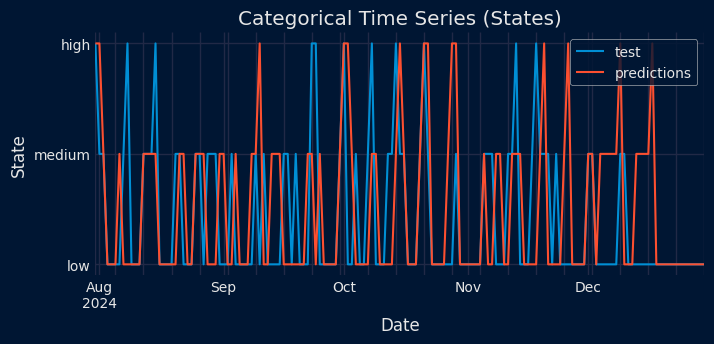

In [83]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data.loc[predictions.index, 'encoded_value'].plot(ax=ax, label='test')
predictions.assign(encoded_value=predictions['pred'].map(encode_mapping))['encoded_value'].plot(ax=ax, label='predictions')
y_ticks = list(encode_mapping.values())
y_labels = list(encode_mapping.keys())
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_labels)
ax.set_title("Categorical Time Series (States)")
ax.set_xlabel("Date")
ax.set_ylabel("State")
ax.legend();

## Hyperparameter tuning

[Hyperparameter tuning](../user_guides/hyperparameter-tuning-and-lags-selection.html) for `ForecasterRecursiveClassifier` can be performed using the functions available in the `skforecast.model_selection` module, such as `grid_search_forecaster`, `random_search_forecaster` and `bayesian_search_forecaster`. These functions allow for systematic exploration of hyperparameter combinations to identify the best configuration for the forecaster based on specified evaluation metrics suitable for classification tasks.

When performing hyperparameter tuning, it is important to use a train-validation-test split approach. This involves dividing the dataset into three distinct subsets:

- Training set: Used to fit the model.
- Validation set: Used to tune the hyperparameters.
- Test set: Used to evaluate the model's performance.

This approach helps to prevent overfitting and ensures that the model generalizes well to unseen data.

In [ ]:
# Train-validation-test split
# ==============================================================================
end_train = '2014-08-31 23:59:00'
end_val ='2014-10-31 23:59:00'
print(
    f"Train dates      : {data.index.min()} --- {data.loc[:end_train].index.max()}"
    f"  (n={len(data.loc[:end_train])})"
)
print(
    f"Validation dates : {data.loc[end_train:].index.min()} --- {data.loc[:end_val].index.max()}"
    f"  (n={len(data.loc[end_train:end_val])})"
)
print(
    f"Test dates       : {data.loc[end_val:].index.min()} --- {data.index.max()}"
    f"  (n={len(data.loc[end_val:])})"
)
print("")

Train dates      : 2023-01-01 00:00:00 --- 2024-03-30 00:00:00  (n=455)
Validation dates : 2024-03-30 00:00:00 --- 2024-07-30 00:00:00  (n=123)
Test dates       : 2024-07-30 00:00:00 --- 2024-12-30 00:00:00  (n=154)



In [ ]:
# Bayesian search hyperparameters and lags with Optuna
# ==============================================================================
regressor = HistGradientBoostingClassifier(
                early_stopping= True,
                random_state=123,
                verbose=0
            )
forecaster = ForecasterRecursiveClassifier(
                regressor         = regressor,
                lags              = 14,  # Placeholder, the value will be overwritten
                window_features   = RollingFeaturesClassification(stats=['proportion'], window_sizes=[72]),
                features_encoding = 'auto',
             )

# Lags used as predictors
lags_grid = [24, (1, 2, 3, 23, 24, 25, 47, 48, 49)]

# Search space
def search_space(trial):
    search_space  = {
        'max_iter' : trial.suggest_int('max_iter', 100, 500, step=100),
        'max_depth'    : trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
        'l2_regularization': trial.suggest_float('l2_regularization', 0.0, 1.0),
        'lags'         : trial.suggest_categorical('lags', lags_grid)
    } 
    return search_space

# Folds
cv_search = OneStepAheadFold(initial_train_size = end_train)

results, best_trial = bayesian_search_forecaster(
                          forecaster          = forecaster,
                          y                   = data.loc[:end_val, 'Demand'],
                          exog                = data.loc[:end_val, ['Temperature', 'Holiday', 'Hour_of_day']],
                          search_space        = search_space,
                          cv                  = cv_search,
                          metric              = 'accuracy_score',
                          kwargs_create_study = {'direction': 'maximize'},
                          n_trials            = 20,
                          random_state        = 123,
                          return_best         = True,
                          n_jobs              = 'auto',
                          verbose             = False,
                          show_progress       = True,
                      )
results.head(4)

  0%|          | 0/20 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'n_estimators': 20, 'min_samples_leaf': 1, 'max_features': 'log2'}
  Backtesting metric: 0.17988939165409754


,lags,params,balanced_accuracy_score,n_estimators,min_samples_leaf,max_features
0,"[1, 2, 3]","{'n_estimators': 20, 'min_samples_leaf': 1, 'm...",0.179889,20,1,log2
1,"[1, 2, 3]","{'n_estimators': 20, 'min_samples_leaf': 1, 'm...",0.179889,20,1,sqrt
2,"[1, 2, 3]","{'n_estimators': 20, 'min_samples_leaf': 1, 'm...",0.179889,20,1,log2
3,"[1, 2, 3]","{'n_estimators': 17, 'min_samples_leaf': 5, 'm...",0.210692,17,5,log2


In [ ]:
# Best model
# ==============================================================================
best_params = results.iloc[-1]['params'].item()
best_lags   = results.iloc[-1]['lags'].item()
forecaster = ForecasterRecursiveClassifier(
               regressor       = HistGradientBoostingClassifier(random_state=123, **best_params),
               lags            = best_lags,
               window_features = RollingFeaturesClassification(stats=['proportion'], window_sizes=[72]),
               features_encoding = 'auto',
             )

============================= 
ForecasterRecursiveClassifier 
============================= 
Classifier: LGBMClassifier 
Lags: [1 2 3] 
Window features: ['roll_proportion_10'] 
Window size: 10 
Series name: y 
Classes: ['high', 'low', 'medium'] 
Number of classes: 3 
Exogenous included: False 
Exogenous names: None 
Feature encoding: auto 
Transformer for exog: None 
Weight function included: False 
Training range: [Timestamp('2023-01-01 00:00:00'), Timestamp('2024-07-30 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: <Day> 
Classifier parameters: 
    {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0,
    'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1,
    'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0,
    'n_estimators': 20, 'n_jobs': None, 'num_leaves': 31, 'objective': None,
    'random_state': 123, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0,
    'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1,
    'min_samples_leaf': 1, 'max_features': 'log2'} 
fit_kwargs: {} 
Creation date: 2025-11-03 10:24:03 
Last fit date: 2025-11-03 10:24:06 
Skforecast version: 0.19.0 
Python version: 3.13.9 
Forecaster id: None

In [ ]:
# Backtest final model on test data
# ==============================================================================
cv = TimeSeriesFold(steps = 24, initial_train_size = end_val)
metric, predictions = backtesting_forecaster(
                          forecaster = forecaster,
                          y          = data['Demand'],
                          exog       = data[['Temperature', 'Holiday', 'Hour_of_day']],
                          cv         = cv,
                          metric     = 'accuracy_score'
                      )
display(metric)
predictions

  0%|          | 0/23 [00:00<?, ?it/s]

,balanced_accuracy_score
0,0.291684


,fold,pred,high_proba,low_proba,medium_proba
2024-03-31,0,medium,0.180394,0.123231,0.696375
2024-04-01,0,medium,0.182249,0.122065,0.695686
2024-04-02,0,medium,0.358463,0.082613,0.558924
2024-04-03,0,high,0.609439,0.083244,0.307317
2024-04-04,0,high,0.832901,0.049463,0.117636
...,...,...,...,...,...
2024-12-26,22,medium,0.079160,0.061959,0.858881
2024-12-27,22,medium,0.070666,0.094459,0.834875
2024-12-28,22,low,0.379732,0.501082,0.119186
2024-12-29,22,low,0.040682,0.906566,0.052752


In [ ]:
# Summary of classification metrics on test set
# ==============================================================================
print("Classification Report \n---------------------")
print(
    classification_report(
        data.loc[predictions.index, 'Demand'],
        predictions['pred']
    )
)

Classification Report 
---------------------
              precision    recall  f1-score   support

        high       0.17      0.21      0.19        56
         low       0.47      0.45      0.46       125
      medium       0.23      0.21      0.22        94

    accuracy                           0.32       275
   macro avg       0.29      0.29      0.29       275
weighted avg       0.33      0.32      0.32       275



## Probability calibration

Well calibrated classifiers are probabilistic classifiers for which the output of the `predict_proba` method can be directly interpreted as a confidence level. For instance, a well calibrated (binary) classifier should classify the samples such that among the samples to which it gave a `predict_proba` value close to, say, 0.8, approximately 80% actually belong to the positive class.

Before we show how to re-calibrate a classifier, we first need a way to detect how good a classifier is calibrated.

### Calibration curves

The following definition of calibration curves is taken from [scikit-learn documentation](https://scikit-learn.org/stable/modules/calibration.html#calibration-curves):

"Calibration curves, also referred to as reliability diagrams, compare how well the probabilistic predictions of a binary classifier are calibrated. It plots the frequency of the positive label (to be more precise, an estimation of the conditional event probability ) on the y-axis against the predicted probability predict_proba of a model on the x-axis. The tricky part is to get values for the y-axis. In scikit-learn, this is accomplished by binning the predictions such that the x-axis represents the average predicted probability in each bin. The y-axis is then the fraction of positives given the predictions of that bin, i.e. the proportion of samples whose class is the positive class (in each bin)."

Since calibration curves are defined for binary classifiers, in the case of multi-class classification problems, one-vs-rest calibration curves are used. This means that for each class, the samples belonging to that class are considered as positive samples, while all other samples are treated as negative samples.

In [ ]:
# Calibration plots: one-vs-rest
# ==============================================================================
for level, code in {'low': 0, 'medium': 1, 'high': 2}.items():
    fig, ax = plt.subplots(figsize=(6, 2.5))
    y_prob = predictions.loc[:, f'{level}_proba'].rename(code)
    y_true = (data.loc[predictions.index, 'encoded_value'] == code).astype(int)
    curve_prob_true, curve_prob_pred = calibration_curve(
        y_true=y_true,
        y_prob=y_prob,
        n_bins=10
    )
    disp = CalibrationDisplay(prob_true=curve_prob_true, prob_pred=curve_prob_pred, y_prob=y_prob)
    disp.plot(name=level, ax=ax, color='C'+str(code))
    ax.set_title(f"{level}")
    ax.set_xlabel("Mean predicted probability")
    ax.set_ylabel("Fraction of positives")
    ax.get_lines()[0].set_color('white')

The calibrations curves show that the classifier is not well calibrated, as the curves deviate significantly from the diagonal line representing perfect calibration. For example, for the class 'low', when the classifier predicts a probability of 0.8, the actual frequency of the positive class is only around 0.5, indicating overconfidence in its predictions for that class.

### Calibration

The calibration of a classification model refers to the process of adjusting the predicted probabilities so that they align with the actual observed outcomes. In other words, calibration corrects the model when it tends to systematically overestimate or underestimate probabilities.

A model is said to be perfectly calibrated if, for any predicted probability $p \in [0, 1]$, the proportion of correctly classified observations among those predicted with probability $p$ is exactly $p$. Formally:

$$
P(\hat{Y} = Y \mid \hat{P} = p) = p, \quad \forall p \in [0, 1]
$$

where:  
- $\hat{Y}$ is the predicted class,  
- $Y$ is the true class, and  
- $\hat{P}$ is the predicted probability of the positive (or target) class.

For example, if we look at all cases where the model predicts a probability of $\hat{P} = 0.8$, we would expect that about 80% of those cases truly belong to the positive class.  

When a model is perfectly calibrated, plotting the observed frequencies against the predicted probabilities produces a **diagonal line** (the identity function) across the range $[0, 1]$:

$$
\text{Observed frequency} = \text{Predicted probability}
$$


The [`CalibratedClassifierCV`](https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html) class in sklearn is used to calibrate a classifier. Since skforecast is compatible with scikit-learn, `CalibratedClassifierCV` can be used directly into [`ForecasterRecursiveClassifier`](https://skforecast.org/0.18.0/api/forecasterrecursive#forecasterrecursiveclassifier).

In [ ]:
# Forecaster with calibrated classifier
# ==============================================================================
regressor = CalibratedClassifierCV(
                estimator = HistGradientBoostingClassifier(
                                **best_params,
                                random_state=123
                            ),
                method   = 'sigmoid',
                ensemble = False, # False to speed up prediction
                cv       = 3,
            )

forecaster = ForecasterRecursiveClassifier(
                regressor       = regressor,
                lags            = best_lags,
                window_features = RollingFeaturesClassification(stats=['proportion'], window_sizes=[72]),
                features_encoding= 'auto',
             )


cv = TimeSeriesFold(steps = 24, initial_train_size = end_val)
metric, predictions = backtesting_forecaster(
                          forecaster = forecaster,
                          y          = data['Demand'],
                          exog       = data[['Temperature', 'Holiday', 'Hour_of_day']],
                          cv         = cv,
                          metric     = 'accuracy_score'
                      )
display(metric)
predictions

In [ ]:
# Calibration plots: one-vs-rest
# ==============================================================================
for level, code in {'low': 0, 'medium': 1, 'high': 2}.items():
    fig, ax = plt.subplots(figsize=(6, 2.5))
    y_prob = predictions.loc[:, f'{level}_proba'].rename(code)
    y_true = (data.loc[predictions.index, 'encoded_value'] == code).astype(int)
    prob_true, prob_pred = calibration_curve(
        y_true=y_true,
        y_prob=y_prob,
        n_bins=10
    )
    disp = CalibrationDisplay(prob_true=prob_true, prob_pred=prob_pred, y_prob=y_prob)
    disp.plot(name=level, ax=ax, color='C'+str(code))
    ax.set_title(f"{level}")
    ax.set_xlabel("Mean predicted probability")
    ax.set_ylabel("Fraction of positives")
    ax.get_lines()[0].set_color('white')

After applying calibration techniques, the calibration curves are much closer to the diagonal line, indicating that the predicted probabilities are now more aligned with the actual observed frequencies. For instance, for the class 'low', when the classifier predicts a probability of 0.8, the actual frequency of the positive class is now around 0.75, showing a significant improvement compared to before calibration.